## 1. Implement models in Stan 

Call center data set — exponential likelihood with gamma prior. Estimate the number of calls per minute for the 11th hour of the call center data set.
Results to compute:
- Posterior 95% confidence interval over λ (check that it matches results in the
solution notebook below)
- Histogram of posterior λ samples

Resources for you to use:
- Data set: call_center.csv
- Solution for class activity (call_center_solution.ipynb)

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np
import pystan
import matplotlib.mlab as mlab

waiting_times_day = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00073825-8976/call-center.csv", 
                                header = None)

current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day.iloc[:,0]:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

In [185]:
stan_code = """
data {  
    int<lower=1> N;
    real<lower=0> y[N];  // waiting time before call
    real<lower=0> alpha;
    real<lower=0> beta;
}

parameters {
    real<lower=0> lambda;  
}

model {
    lambda ~ gamma(alpha, beta);  // prior over p
    y ~ exponential(lambda);
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_517b0b5d84655d237d93c53821eb81b3 NOW.


Inference for Stan model: anon_model_517b0b5d84655d237d93c53821eb81b3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
lambda   14.9    0.01   0.51  13.92  14.89  15.88   1564    1.0

Samples were drawn using NUTS at Thu Oct 18 19:53:19 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


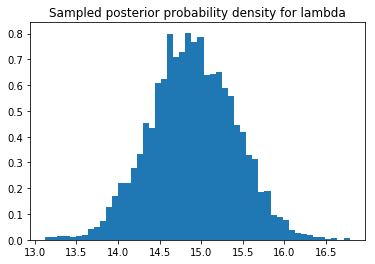

Posterior 95% confidence interval for lambda: [13.91717958 15.8810152 ]


In [186]:
data = {'N': len(waiting_times_per_hour[11]), 
        'y': waiting_times_per_hour[11], 
        'alpha': 1,
       'beta': 0.25}

stan_results = stan_model.sampling(data=data)
print(stan_results.stansummary(pars=['lambda'], probs=[0.025, 0.5, 0.975]))

posterior_samples = stan_results.extract()
plt.hist(posterior_samples['lambda'], bins=50, density=True)
plt.title('Sampled posterior probability density for lambda')
plt.show()
print("Posterior 95% confidence interval for lambda:", np.percentile(posterior_samples['lambda'], [2.5, 97.5]))

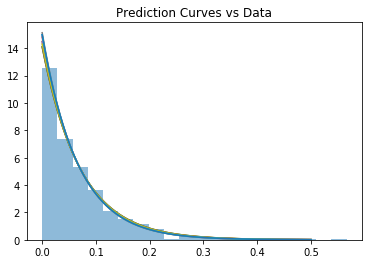

In [215]:
plt.hist(waiting_times_per_hour[11], density=True, bins=20, alpha = 0.5, lw = 3)
choices = np.random.choice(posterior_samples['lambda'], 10, replace = False)
for i in choices:
    x = np.linspace(0, 0.5, 1000)
    plt.plot(x, ss.expon.pdf(x, loc = 0, scale = 1/i))
plt.title("Prediction Curves vs Data")
plt.show()

## 2. Normal likelihood with normal-inverse-gamma prior
Results to compute:
- 95% posterior confidence intervals for the mean μ and variance σ of the data.
- Take 10 samples from your posterior over μ and σ^2 and plot the normal distributions corresponding to them. See Task 3 in the solutions below — you should produce a plot similar the one you find there.

In [236]:
stan_code = """
data {
   real mu;
   real nu;
   real<lower=0> alpha;
   real<lower=0> beta;
   int<lower=1> N;
   real y[N];
}

parameters {
    real mean1;
    real<lower=0> var1;
}
model {
   mean1 ~ normal(mu, sqrt(var1/nu));
   var1 ~ inv_gamma(alpha, beta);
   y ~ normal(mean1, sqrt(var1));
}
"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5113ce65f97ef3078ae8bcb7b8cad5cd NOW.


In [243]:
arr = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
data = {'N': len(arr), 'y': arr, 'mu': 0, 'nu':  0.054, 'alpha': 1.12, 'beta': 0.4,}

stan_results = stan_model.sampling(data=data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['mean1', 'var1'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_5113ce65f97ef3078ae8bcb7b8cad5cd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mean1   3.06  2.3e-3   0.14    2.8   3.06   3.33   3567    1.0
var1    3.62  6.3e-3   0.36   2.98    3.6    4.4   3304    1.0

Samples were drawn using NUTS at Thu Oct 18 20:59:52 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [242]:
print("Posterior 95% confidence interval for mu:", np.percentile(posterior_samples['mean1'], [2.5, 97.5]))
print("Posterior 95% confidence interval for variance:", np.percentile(posterior_samples['var1'], [2.5, 97.5]))

Posterior 95% confidence interval for mu: [2.80291685 3.32203291]
Posterior 95% confidence interval for variance: [2.95016328 4.39984258]


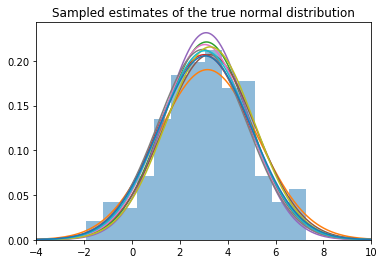

In [289]:
meanvars = list(zip(posterior_samples['mean1'], posterior_samples['var1']))
plt.hist(arr, density = True, bins = 13, alpha = 0.5, lw = 3)

x = np.linspace(-4, 10, 1000)
for i in np.random.randint(0, 4000, 10):
    plt.plot(x, ss.norm.pdf(norm, meanvars[i][0], np.sqrt(meanvars[i][1])) )

plt.title('Sampled estimates of the true normal distribution')
plt.xlim(-4, 10)
plt.show()

## 3. Log-normal HRTEM data.
Normal likelihood log-transformed data and using a normal-inverse-gamma prior
Results to compute:
- 95% posterior confidence intervals for the μ and variance σ^2 of the log-transformed data. (Should match results under Task 3 of the solutions.)
- Take 10 samples from your posterior over μ and σ^2 and plot the log-normal distributions corresponding to them. See Task 5 in the solutions below — you should produce a plot similar the one you find there, but with 10 pdfs rather than one.

In [290]:
stan_code = """
data {
   real mu;
   real nu;
   real<lower=0> alpha;
   real<lower=0> beta;
   int<lower=1> N;
   real y[N];
}

transformed data {
    real logy[N];
    logy = log(y);
}

parameters {
    real mean1;
    real<lower=0> var1;
}

model {
   mean1 ~ normal(mu, sqrt(var1/nu));
   var1 ~ inv_gamma(alpha, beta);
   logy ~ normal(mean1, sqrt(var1));
}
"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1789d37c32094fa2ce0ad47ee3144e54 NOW.


In [291]:
df = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv", header = None)
data = {'y':df.iloc[:,0], 'N': len(df.iloc[:,0]), 'mu': 2.3, 'nu': 0.1, 'alpha': 2, 'beta': 5}

stan_results = stan_model.sampling(data=data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['mean1', 'var1'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_1789d37c32094fa2ce0ad47ee3144e54.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mean1   1.89  5.4e-4   0.03   1.83   1.89   1.96   3289    1.0
var1     0.5  5.9e-4   0.03   0.44   0.49   0.56   2802    1.0

Samples were drawn using NUTS at Thu Oct 18 21:17:53 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [292]:
print("Posterior 95% confidence interval for mu:", np.percentile(posterior_samples['mean1'], [2.5, 97.5]))
print("Posterior 95% confidence interval for variance:", np.percentile(posterior_samples['var1'], [2.5, 97.5]))

Posterior 95% confidence interval for mu: [1.83286591 1.95540829]
Posterior 95% confidence interval for variance: [0.4384997  0.56180771]


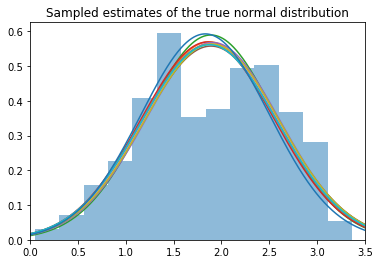

In [342]:
meanvars = list(zip(posterior_samples['mean1'], posterior_samples['var1']))
plt.hist(np.log(df.iloc[:,0]), bins = 13, density = True, alpha = 0.5, lw = 3)

x = np.linspace(0, 3.5, 1000)
for i in np.random.randint(0, 4000, 10):
    plt.plot(x, ss.norm.pdf(x, meanvars[i][0], np.sqrt(meanvars[i][1])) )


plt.title('Sampled estimates of the true normal distribution')
plt.xlim(0, 3.5)
plt.show()

## Stretch goal (optional)
Fit a mixture of two Gaussians to the HRTEM data set using Stan. Your likelihood function for each datum should be
That is, with probability p the log of the datum is generated from the first Gaussian and with probability (1 − p) it is generated from the second Gaussian. 
Produce plots and summaries of your posteriors over all parameters. Use samples from the posterior to show whether and how well the likelihood functions corresponding to the samples match the data histogram.
Note: You have to be really careful when fitting a mixture model like this one, since the posterior is always bimodal. For example if

In [348]:
stan_code = """
data {
    int<lower=1> K; // number of mixture components
    int<lower=1> N; // number of data points
    real y[N]; // observations
    real mu_prior;
    real<lower=0> nu;
    real<lower=0> alpha;
    real<lower=0> beta;
}
parameters {
    simplex[K] theta; // mixing proportions
    ordered[K] mu; // locations of mixture components
    vector<lower=0>[K] sigma;  // scales of mixture components
}
model {
    vector[K] log_theta = log(theta);  // cache log calculation
    mu ~ normal(mu_prior, sqrt(sigma/nu));
    sigma ~ inv_gamma(alpha, beta);

    for (n in 1:N) {
        vector[K] lps = log_theta;
        for (k in 1:K) {
            lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
        }
    target += log_sum_exp(lps);
    }
}

"""
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0e4ad7cf15bbcab2837ae684dcf5707b NOW.


In [349]:
df = pd.read_csv("https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv", header = None)
data = {'y':np.log(df.iloc[:,0]), 'N': len(df.iloc[:,0]), 'K':2, 'mu_prior': 2.3, 'nu': 0.1, 'alpha': 1, 'beta': 1}
stan_results = stan_model.sampling(data=data)
posterior_samples = stan_results.extract()
print(stan_results.stansummary(pars=['theta', 'mu', 'sigma'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_0e4ad7cf15bbcab2837ae684dcf5707b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
theta[1]   0.58  1.9e-3   0.06   0.47   0.58   0.71   1050    1.0
theta[2]   0.42  1.9e-3   0.06   0.29   0.42   0.53   1050    1.0
mu[1]      1.44  2.6e-3   0.08    1.3   1.44   1.62    960    1.0
mu[2]      2.52  1.3e-3   0.05   2.41   2.52   2.62   1592    1.0
sigma[1]    0.5  1.4e-3   0.05   0.42    0.5    0.6   1091    1.0
sigma[2]   0.35  7.8e-4   0.03   0.29   0.35   0.41   1587    1.0

Samples were drawn using NUTS at Thu Oct 18 21:32:51 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [379]:
print("Posterior 95% confidence interval for theta:", 
      np.transpose(np.percentile(posterior_samples['theta'], [2.5, 97.5], axis = 0))[0])
print("Posterior 95% confidence interval for mu1:", 
      np.transpose(np.percentile(posterior_samples['mu'], [2.5, 97.5], axis = 0))[0])
print("Posterior 95% confidence interval for mu2:", 
      np.transpose(np.percentile(posterior_samples['mu'], [2.5, 97.5], axis = 0))[1])
print("Posterior 95% confidence interval for sigma1:", 
      np.transpose(np.percentile(posterior_samples['sigma'], [2.5, 97.5], axis = 0))[0])
print("Posterior 95% confidence interval for sigma2:", 
      np.transpose(np.percentile(posterior_samples['sigma'], [2.5, 97.5], axis = 0))[1])

Posterior 95% confidence interval for theta: [0.47083897 0.71281885]
Posterior 95% confidence interval for mu1: [1.29711666 1.615554  ]
Posterior 95% confidence interval for mu2: [2.40972228 2.61787686]
Posterior 95% confidence interval for sigma1: [0.41702876 0.6032433 ]
Posterior 95% confidence interval for sigma2: [0.28924706 0.41178372]


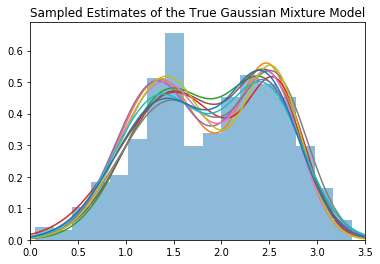

In [436]:
plt.hist(np.log(df.iloc[:,0]), bins=17, density=True, alpha = 0.5)

x = np.arange(0, 3.5, 0.01)
for i in np.random.randint(0, 4000, 10):
    thetamusigma = zip(posterior_samples['theta'], posterior_samples['mu'], posterior_samples['sigma'])
    pdfs = [theta * ss.norm.pdf(x, mu, sigma) for theta, mu, sigma in np.transpose(list(thetamusigma)[i])]
    plt.plot(x, np.sum(np.array(pdfs), axis=0))
    
plt.title("Sampled Estimates of the True Gaussian Mixture Model")
plt.xlim(0, 3.5)
plt.show()